In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pImpactR import plot

### def : toy model parameters

In [2]:
# toy model param
tunex = 0.33
psi = 2*np.pi*tunex
alpha = 0.1

# control param
q_max = 12.0
k_max = 0.04

# dist param
Emit = np.array([0.001,0.01,0.1])
nEmit = len(Emit)
q0 = 0.240876837
p0 = -0.43815334002193
xi0 = (q0**2+p0**2)**0.5
Xi0 = np.zeros(nEmit)
print(xi0)

Delta = 0.2
legend = [r'$\epsilon_0 = $'+str(emit) for emit in Emit]

0.4999999999754976


### Toy Model<center> $H = \frac{x^2 + p^2}{2} + \frac{\alpha}{2} \left(\frac{x^2 + p^2}{2}\right)^2$ </center>

In [3]:
def Map(z):
    action = 0.5*np.abs(z)**2
    return z*np.exp(-1j*(psi+action*alpha))
Map = np.vectorize(Map)

### def : getCentroidData

In [4]:
def getCentroidData(nTurn,pDataN,emit0):
    pData = emit0**0.5*(pDataN[:,0]+1j*pDataN[:,1]) + q0 + 1j*p0    
    cData = np.zeros(nTurn,dtype=np.complex)
    for i in range(nTurn):
        cData[i] = np.sum(pData)/npt
        pData = Map(pData)
    return cData

### get cData from tracking

In [5]:
import pickle
nTurn = []
cData = []
EmitMeas = [0]*nEmit
npt = 100000
pDataN = np.random.normal(size=(npt,2))
for i in range(len(Emit)):
    nTurn.append(int(6.0/(Emit[i]**0.5*np.abs(alpha)*xi0)))
    pData = Emit[i]**0.5*(pDataN[:,0]+1j*pDataN[:,1])
    pData = pData + 4*Delta*(np.imag(pData))**3
    EmitMeas[i]= np.sum(np.abs(pData)**2/2)/npt
    print(Emit[i],EmitMeas[i],nTurn[i])
#     cData.append(getCentroidData(nTurn[i],pDataN,Emit[i]))
    
# with open('cData.Meas.ChadsParam.pickle', 'wb') as f:
#     pickle.dump(cData, f)
    
with open('cData.Meas.ChadsParam.pickle', 'rb') as f:
    cData=pickle.load(f)

0.001 0.0010019263834636467 3794
0.01 0.010023062108727736 1200
0.1 0.1050553302057047 379


In [6]:
for i in range(nEmit):
    cData[i] = cData[i] + 4*Delta*(np.imag(cData[i]))**3

### measure detuning (ideal)

0.015914788558363948
0.015915494309189534


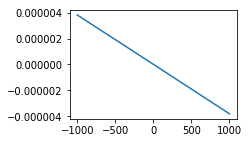

In [7]:
from pImpactR.util import naff
nSample = 5
Zt = np.zeros((nSample,2048),dtype=np.complex)
emitlist = np.zeros(nSample)
Tune = np.zeros(nSample)
delta = 1.0e-3
k=0
for d in np.linspace(-delta,+delta,nSample):
    Z = q0+1j*p0 + d
    for i in range(2048):
        Zt[k][i] = Z
        Z = Map(Z)
    emitlist[k] = np.abs(Zt[k][0])**2/2.0
    Tune[k],amp,data = naff(1,Zt[k])
    k=k+1

plt.figure(figsize=(3,2))
plt.plot(np.linspace(-delta,delta,nSample)*1.0e6,Tune-Tune[int(nSample/2)])
print(-(Tune[-1]-Tune[0])/(emitlist[-1]-emitlist[0]))
print(alpha/2/np.pi)
alpha = -2*np.pi*(Tune[-1]-Tune[0])/(emitlist[-1]-emitlist[0])

### measure detuning (physical)

0.02208353405223098
0.015914788558363945


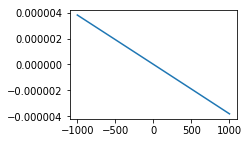

In [8]:
from pImpactR.util import naff
nSample = 5
Zt = np.zeros((nSample,2048),dtype=np.complex)
emitlist = np.zeros(nSample)
Tune = np.zeros(nSample)
delta = 1.0e-3
k=0
for d in np.linspace(-delta,+delta,nSample):
    Z = q0+1j*p0 + d
    for i in range(2048):
        Zt[k][i] = Z
        Z = Map(Z)
    Zt[k] = Zt[k] + 4*Delta*(np.imag(Zt[k]))**3
    emitlist[k] = np.abs(Zt[k][0])**2/2.0
    Tune[k],amp,data = naff(1,Zt[k])
    k=k+1

plt.figure(figsize=(3,2))
plt.plot(np.linspace(-delta,delta,nSample)*1.0e6,Tune-Tune[int(nSample/2)])
print(-(Tune[-1]-Tune[0])/(emitlist[-1]-emitlist[0]))
print(alpha/2/np.pi)
alpha = -2*np.pi*(Tune[-1]-Tune[0])/(emitlist[-1]-emitlist[0])

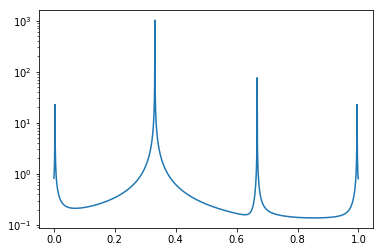

In [9]:
fft = np.fft.fft(Zt[2])
plt.semilogy(np.arange(len(Zt[2]))/len(Zt[2]),np.abs(fft[::-1]))

### measure offset

In [10]:
# for i in range(len(Emit)):
#     cData[i]=np.real(cData[i])

In [11]:
plt.figure(figsize=(12,3))
for i in range(len(Emit)):
#     iMax=np.argmax(np.abs(cData[i]))
#     cData[i]=cData[i][iMax:]
    Xi0[i]=np.abs(cData[i][0])
    nTurn[i]=len(cData[i])
    cData[i]=cData[i]/cData[i][0]
    print(Xi0[i])

0.4712891188068288
0.47129760454717545
0.4713253747854068


<Figure size 864x216 with 0 Axes>

### get cData from modeling

In [12]:
def GaussDist(x):
    return np.exp(-x**2/2.0)/np.sqrt(2.0*np.pi)

Q = np.linspace(-q_max,q_max,2048)
histData = GaussDist(Q)
dq = Q[1]-Q[0]

cDataModel = [0]*len(Emit)
for i in range(len(Emit)):
    cDataModel[i]=np.zeros(nTurn[i],dtype=np.complex)
    for t in range(nTurn[i]):
        cDataModel[i][t] = np.sum(histData*np.exp(-1j*t*Emit[i]**0.5*Q*Xi0[i]*alpha)*dq)*np.exp(-1j*psi*t)    
    cDataModel[i] = cDataModel[i]/cDataModel[i][0]

# Compare cData Time Domain

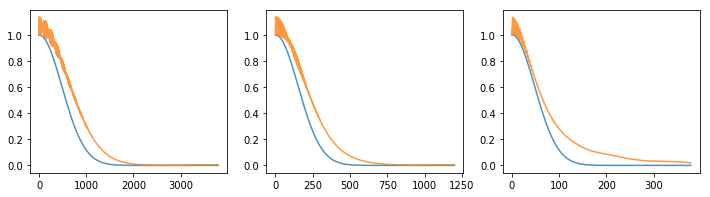

In [13]:
nEmit = len(Emit)
plt.figure(figsize=(nEmit*4,3))
for i in range(nEmit):
    plt.subplot(1,nEmit,i+1)
    plt.plot(np.abs(cDataModel[i]),alpha=0.8)
    plt.plot(np.abs(cData[i]),     alpha=0.8)

# Compare cData Freq Domain

In [14]:
# from pImpactR.util import naff
TuneNaff = np.zeros(nEmit)
AmpNaff  = [0]*nEmit
# for i in range(nEmit):
#     TuneNaff[i], AmpNaff[i], testData1 = naff(1,cData[i])
#     TuneNaff[i] = 1.0 - TuneNaff[i]

In [15]:
print(TuneNaff)
TuneNaff = [tunex + 0.1/(2*np.pi)*(xi0**2/2)]*nEmit
print(TuneNaff)

[0. 0. 0.]
[0.3319894367884537, 0.3319894367884537, 0.3319894367884537]


In [16]:
nSample = 2048*2
K = np.linspace(-k_max,k_max,nSample)
Tune = [0]*nEmit
Amp  = [0]*nEmit
for i in range(nEmit):
    T = len(cData[i])
    Amp[i] = np.zeros(nSample,dtype=np.complex)
    Tune[i] = TuneNaff[i] + K
    for k in range(nSample):
        Amp[i][k] = np.sum(cData[i]*np.exp(2j*np.pi*Tune[i][k]*np.arange(0,T)))
    Amp[i] = Amp[i]*Emit[i]**0.5

In [17]:
Q = Q
histData = histData*np.pi/np.abs(Xi0[0]*alpha)

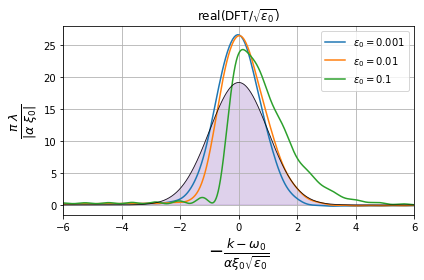

In [18]:
from scipy.signal import hilbert
# plt.figure(figsize=(12,4))

# plt.subplot(1,2,1)
for i in range(nEmit):
    plt.plot(2*np.pi*K/(Emit[i]**0.5*Xi0[i]*alpha),np.real(Amp[i]))
plt.plot(Q,histData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q, 0, histData,color='C4',alpha=0.3)
plt.xlim(-6.0,6.0)
plt.xlabel(r'$-\frac{k-\omega_0}{\alpha \xi_0 \sqrt{\epsilon_0}}$',fontsize=18);
plt.ylabel(r'$\frac{\pi\,\,\lambda}{|\alpha\,\,\xi_0|}$',fontsize=18);
plt.title('real(DFT$/\sqrt{\epsilon_0}$)',fontsize=12);
plt.legend(legend)
plt.grid()

# hilbertData = np.imag(hilbert(histData))
# plt.subplot(1,2,2)
# for i in range(nEmit):
#     plt.plot(2*np.pi*K/(Emit[i]**0.5*Xi0[i]*alpha),np.imag(Amp[i]))
# plt.plot(Q,hilbertData,color='k',alpha=0.9,linewidth=0.8)
# plt.fill_between(Q, 0, hilbertData,color='C4',alpha=0.3)
# plt.xlabel(r'$\frac{\omega-\omega_0}{\alpha q_0 \sqrt{\epsilon_0}}$',fontsize=16);
# plt.xlim(-8.0,8.0)
# plt.legend(legend)
# plt.grid()
plt.tight_layout()

In [19]:
histData = histData*np.abs(alpha)
alpha = 0.1
histData = histData/np.abs(alpha)

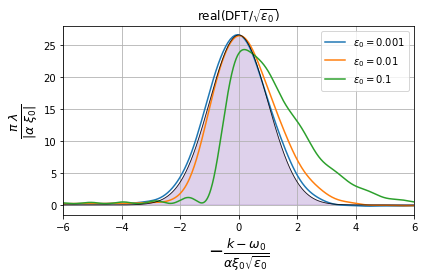

In [20]:
from scipy.signal import hilbert
# plt.figure(figsize=(12,4))

# plt.subplot(1,2,1)
for i in range(nEmit):
    plt.plot(2*np.pi*K/(Emit[i]**0.5*Xi0[i]*alpha),np.real(Amp[i]))
plt.plot(Q,histData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q, 0, histData,color='C4',alpha=0.3)
plt.xlim(-6.0,6.0)
plt.xlabel(r'$-\frac{k-\omega_0}{\alpha \xi_0 \sqrt{\epsilon_0}}$',fontsize=18);
plt.ylabel(r'$\frac{\pi\,\,\lambda}{|\alpha\,\,\xi_0|}$',fontsize=18);
plt.title('real(DFT$/\sqrt{\epsilon_0}$)',fontsize=12);
plt.legend(legend)
plt.grid()

# hilbertData = np.imag(hilbert(histData))
# plt.subplot(1,2,2)
# for i in range(nEmit):
#     plt.plot(2*np.pi*K/(Emit[i]**0.5*Xi0[i]*alpha),np.imag(Amp[i]))
# plt.plot(Q,hilbertData,color='k',alpha=0.9,linewidth=0.8)
# plt.fill_between(Q, 0, hilbertData,color='C4',alpha=0.3)
# plt.xlabel(r'$\frac{\omega-\omega_0}{\alpha q_0 \sqrt{\epsilon_0}}$',fontsize=16);
# plt.xlim(-6.0,6.0)
# plt.legend(legend)
# plt.grid()
plt.tight_layout()